<a href="https://www.kaggle.com/code/zeeshanahmadyar/different-classificatioin-model-titanac-dataset?scriptVersionId=282592180" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-data/Titanic.csv


In [2]:
df = pd.read_csv('/kaggle/input/titanic-data/Titanic.csv')
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,0,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,1,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,0,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,0,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


# **Fill missing values**

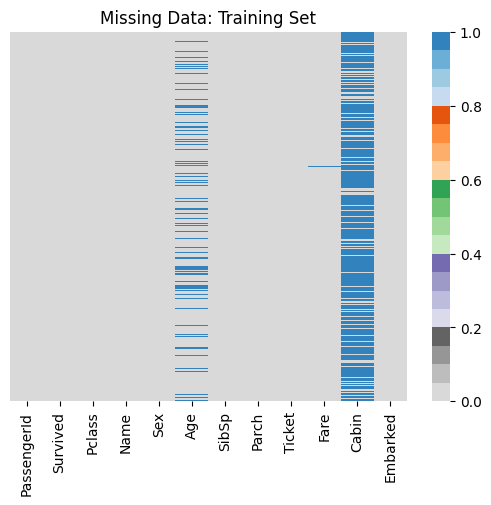

In [3]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='tab20c_r')
plt.title('Missing Data: Training Set')
plt.show()

In [4]:
# Drop cabin Fare
df.drop('Cabin', inplace=True, axis=1)

# **Detecting and removing Outliers**

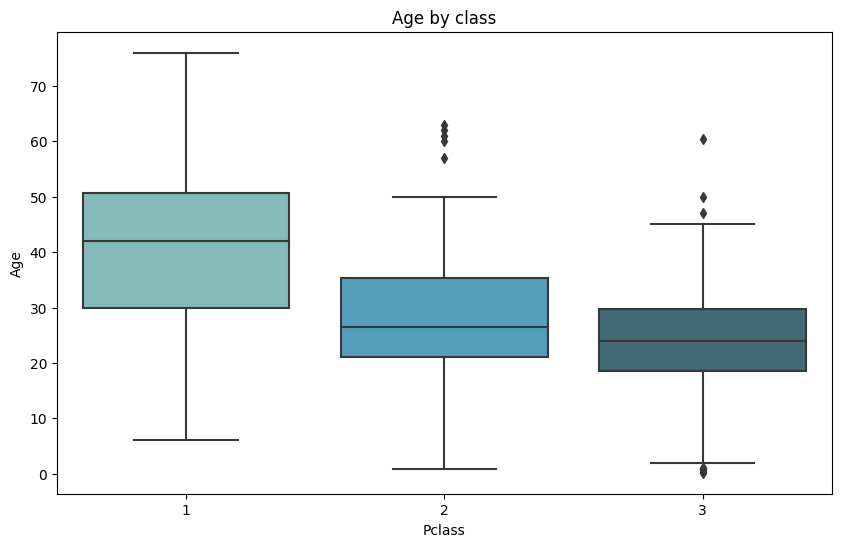

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Age', data=df, palette='GnBu_d').set_title('Age by class')
plt.show()

<Axes: >

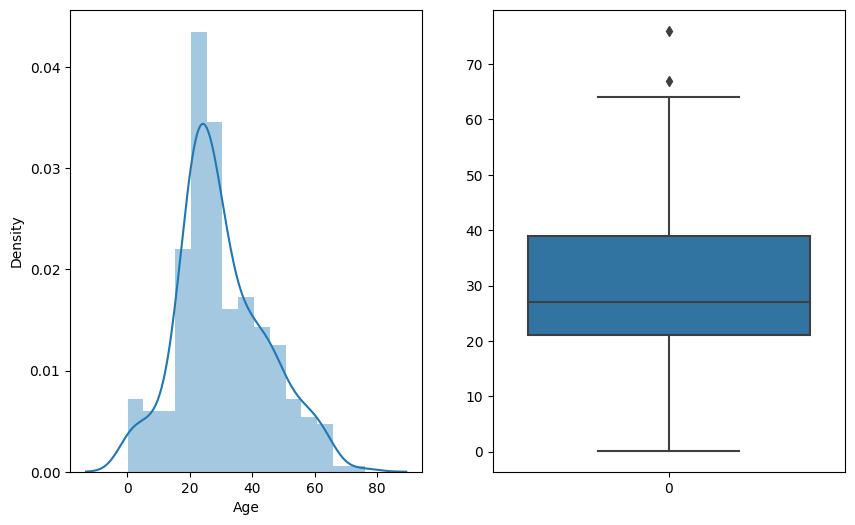

In [6]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.distplot(df['Age'])

plt.subplot(1, 2, 2)
sns.boxplot(df['Age'])

# **Remove Outliers using Persontile**

In [7]:
upper_limit = df['Age'].quantile(0.99)
lower_limit = df['Age'].quantile(0.01)

In [8]:
df['Age'] = np.where(df['Age'] >= upper_limit,
                    upper_limit,
                    np.where(df['Age'] <= lower_limit,
                            lower_limit,
                            df['Age']
                            )
                    )

# **Fill missing Values with the mean**

In [9]:
# calculate the mean by classes
class1_mean = df[df['Pclass'] == 1]['Age'].mean()
class2_mean = df[df['Pclass'] == 2]['Age'].mean()
class3_mean = df[df['Pclass'] == 3]['Age'].mean()

def impute_age(col):
    Age = col[0]
    Pclass = col[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return class1_mean
        elif Pclass == 2:
            return class2_mean
        else:
            return class3_mean
    else:
        return Age

In [10]:
df['Age'] = df[['Pclass', 'Age']].apply(impute_age, axis=1)

# **Now we remove columns with no or weak relation**

In [11]:
df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
df.dropna(inplace=True)

In [12]:
df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,3.0,0,0,7.8292,Q
1,1,3,female,3.0,1,0,7.0000,S
2,0,2,male,2.0,0,0,9.6875,Q
3,0,3,male,3.0,0,0,8.6625,S
4,1,3,female,3.0,1,1,12.2875,S
5,0,3,male,3.0,0,0,9.2250,S
6,1,3,female,3.0,0,0,7.6292,Q
7,0,2,male,2.0,1,1,29.0000,S
8,1,3,female,3.0,0,0,7.2292,C
9,0,3,male,3.0,2,0,24.1500,S


# **Encode categorical features**

In [13]:
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], dtype=int, drop_first=True)

In [14]:
df.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,3.0,0,0,7.8292,1,1,0
1,1,3,3.0,1,0,7.0000,0,0,1
2,0,2,2.0,0,0,9.6875,1,1,0
3,0,3,3.0,0,0,8.6625,1,0,1
4,1,3,3.0,1,1,12.2875,0,0,1
5,0,3,3.0,0,0,9.2250,1,0,1
6,1,3,3.0,0,0,7.6292,0,1,0
7,0,2,2.0,1,1,29.0000,1,0,1
8,1,3,3.0,0,0,7.2292,0,0,0
9,0,3,3.0,2,0,24.1500,1,0,1


# **Divide data into input and Target Variable**

In [15]:
X = df.drop('Survived', axis=True)
y = df['Survived']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

# **Scaled Numerical Data**

In [17]:
# create instance for standard scaler
scaler = StandardScaler()

In [18]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **LogisticRegression**
***Create instance of Model***

In [19]:
Lreg = LogisticRegression()

In [20]:
Lreg.fit(X_train_scaled, y_train)

LogisticRegression()

# **Model Evaluation LogisticRegression**

In [21]:
y_pred_Lreg = Lreg.predict(X_test)
print('LogisticRegression:')
print('-' * 22)
Lreg_accuracy = round(accuracy_score(y_test, y_pred_Lreg) * 100, 2)
print('Accuracy', Lreg_accuracy, '%')

LogisticRegression:
----------------------
Accuracy 67.86 %


# **DecisionTreeClassifier**
Create instance of Model

In [22]:
Dtree = DecisionTreeClassifier()

In [23]:
Dtree.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

# **Model Evaluation Decision Tree**

In [24]:
y_pred_Dtree = Dtree.predict(X_test)
Dtree_accuracy = round(accuracy_score(y_test, y_pred_Dtree) * 100, 2)
print('DecisionTreeClassifier:')
print('-' * 22)
print('Accuracy', Dtree_accuracy, '%')

DecisionTreeClassifier:
----------------------
Accuracy 48.81 %


# **RandomForestClassifier**
Create Model instance

In [25]:
rfc = RandomForestClassifier()

In [26]:
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier()

# **Model Evaluation RandomForestClassifier**

In [27]:
y_pred_rfc = rfc.predict(X_test)
print('RandomForestClassifier:')
print('-' * 22)
rfc_accuracy = round(accuracy_score(y_test, y_pred_rfc) * 100, 2)
print('Accuracy', rfc_accuracy, '%')

RandomForestClassifier:
----------------------
Accuracy 48.81 %


# **GradientBoostingClassifier**
Create Model instance

In [28]:
gbc = GradientBoostingClassifier()

In [29]:
gbc.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

# **Model Evaluation RandomForestClassifier**

In [30]:
y_pred_gbc = gbc.predict(X_test)
print('GradientBoostingClassifier:')
print('-' * 22)
gbc_accuracy = round(accuracy_score(y_test, y_pred_gbc) * 100, 2)
print('Accuracy', gbc_accuracy, '%')

GradientBoostingClassifier:
----------------------
Accuracy 48.81 %


# **Checking Model Evaluation**

In [31]:
model_scores = {
    'Logistic Regression': 67.86,
    'Decision Tree Classifier': 48.81,
    'Random Forest Classifier': 48.81,
    'Gradient Boosting Classifier': 48.81
}

In [32]:
sorted_scores = sorted(model_scores.items(), key= lambda x : x[1], reverse= True)

# **Display Ranking of Models**

In [33]:
print('Model Ranking: (Greater Value better)')
for rank, (model_name, score) in enumerate(sorted_scores, start=1):
    print(f'{rank}. {model_name} {score}')

Model Ranking: (Greater Value better)
1. Logistic Regression 67.86
2. Decision Tree Classifier 48.81
3. Random Forest Classifier 48.81
4. Gradient Boosting Classifier 48.81
